In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter
from IPython.display import Image

# Code for running model below

In [2]:
# Set params for use across all graphs
# If there are problems generating LATEX in graphs, comment out the top two params below
graph_params = {
    'text.latex.preamble': '\\usepackage{gensymb}',
    'text.usetex': True,
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'font.family': 'serif',
    'figure.figsize': [12, 12],
    'font.size': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    "figure.facecolor": 'white',
}
plt.rcParams.update(graph_params)

save_fig_param = False

In [3]:
consts = {
    'f0'   : 10**-4,   #m-1
    'beta' : 10**-11,  #m^-1 s^-1
    'g'    : 10,       #ms^-2
    'gamma': 10**-6,   #s^-1
    'rho'  : 1000,     #kgm^-3
    'H'    : 1000,     #m
    'L'    : 10**6,    #m
    'tau_0': 0.2,      #Nm^-2
}

epsilon = consts['gamma']/(consts['L']*consts['beta'])
a = (-1 - np.sqrt(1 + (2*np.pi*epsilon)**2)) / (2*epsilon)
b = (-1 + np.sqrt(1 + (2*np.pi*epsilon)**2)) / (2*epsilon)

consts['epsilon'] = epsilon
consts['a'] = a
consts['b'] = b

In [4]:
###############################
### Analytical steady state ###
###############################

def f1(x, consts=consts):
    """ 
    Function used to help steady state calculations
    """
    a = consts['a']
    b = consts['b']

    numerator = (np.exp(a)-1)*np.exp(b*x) + (1-np.exp(b))*np.exp(a*x)
    denom = np.exp(b) - np.exp(a)
    return np.pi*(1 + numerator/denom)

def f2(x, consts=consts):
    """ 
    Function used to help steady state calculations
    """
    a = consts['a']
    b = consts['b']

    numerator = (np.exp(a)-1)*b*np.exp(b*x) + (1 - np.exp(b))*a*np.exp(a*x)
    denom = np.exp(b) - np.exp(a)
    return numerator/denom

def get_tau(x, y, consts=consts):
    """
    Function used to get components of tau wind stress for analytic solutions
    """
    tau_0 = consts['tau_0']
    L = consts['L']
    tau_x = -tau_0 * np.cos(np.pi*y/L)
    tau_y = 0
    return [tau_x, tau_y]

def get_u_steady_state(x, y, consts=consts):
    """ 
    Get the u steady state solution at specific x,y point
    """
    tau_0 = consts['tau_0']
    rho = consts['rho']
    H = consts['H']
    L = consts['L']
    gamma = consts['gamma']

    coeff = -tau_0/(np.pi*gamma*rho*H)
    func1 = f1(x/L)
    cosine = np.cos(np.pi*y/L)
    return coeff * func1 * cosine

def get_v_steady_state(x, y, consts=consts):
    """ 
    Get the v steady state solution at specific x,y point
    """
    tau_0 = consts['tau_0']
    rho = consts['rho']
    H = consts['H']
    L = consts['L']
    gamma = consts['gamma']

    coeff = tau_0/(np.pi*gamma*rho*H)
    func2 = f2(x/L)
    sin = np.sin(np.pi*y/L)
    return coeff * func2 * sin

def get_eta_steady_state(x, y, consts=consts):
    """ 
    Get the eta steady state solution at specific x,y point
    """
    tau_0 = consts['tau_0']
    rho = consts['rho']
    H = consts['H']
    L = consts['L']
    g = consts['g']
    f0 = consts['f0']
    beta = consts['beta']
    gamma = consts['gamma']

    coeff  = tau_0/(np.pi*gamma*rho*H)
    coeff *= f0*L/g
    f2_term = gamma*f2(x/L)*np.cos(np.pi*y/L)/(f0*np.pi)
    f1_term_coeff = f1(x/L)/np.pi
    f1_term_sin = np.sin(np.pi*y/L)*(1 + beta*y/f0)
    f1_term_cosine = np.cos(np.pi*y/L)*beta*L/(f0*np.pi)
    return coeff*(f2_term + f1_term_coeff*(f1_term_sin + f1_term_cosine))

def get_steady_state_solutions(dx, dy, eta_0, consts=consts):
    x_range = np.arange(0, consts['L'], dx)
    y_range = np.arange(0, consts['L'], dx)

    nx = int(consts['L']/dx)
    ny = int(consts['L']/dy)

    u_steady_state = np.zeros((ny, nx))
    v_steady_state = np.zeros_like(u_steady_state)
    eta_steady_state = np.zeros_like(u_steady_state)

    for j,y in enumerate(y_range):
        for i,x in enumerate(x_range):
            u_steady_state[j,i] = get_u_steady_state(x,y)
            v_steady_state[j,i] = get_v_steady_state(x,y)
            eta_steady_state[j,i] = eta_0 + get_eta_steady_state(x,y)

    return [x_range, y_range, u_steady_state, v_steady_state, eta_steady_state]

In [5]:
##########################
### Plotting functions ###
##########################

def plot_quiver_field(
    x_array, y_array, u_array, v_array, fig_title, sample_step=1, 
    save_fig=False, fig_name="ocean_gyre_quiver.pdf"):
    """
    Plots the quiver field of u and v components of wind

    Args:
        x_array (nd_array): 
            1D array containing x values
        y_array (nd_array): 
            1D array containing y values
        u_array (nd_array): 
            2D array containing u wind values across all x,y
        v_array (nd_array): 
            2D array containing v wind values across all x,y
        fig_title (string):
            Title to be placed on the figure
        sample_step (int, optional): 
            Sets the step of points to be plotted. Defaults to 1 (all points plotted).
            E.g., sample_step=2 would plot every second point.
        save_fig (bool, optional):
            Flag for saving figure. Default to False
        fig_name (string, optional):
            Name used to save figure if save_fig arg is True. 
            Defaults to "ocean_gyre_quiver.pdf"
    
    Returns:
        None                        
    """

    # Resamples the arrays based on the input sample_step
    x_array = x_array[::sample_step]
    y_array = y_array[::sample_step]
    u_array = u_array[::sample_step, ::sample_step]
    v_array = v_array[::sample_step, ::sample_step]

    # Calculate magnitudes of values in u and v arrays
    magnitude = np.linalg.norm(
        np.dstack((u_array, v_array)),
        axis=2
    )

    # Now, resize to plot in more sensible units
    scale_factor = 10**-6
    x_array = x_array*scale_factor
    y_array = y_array*scale_factor

    # Plot results
    plt.rcParams.update({'figure.figsize': [7.5, 6]})
    col = plt.quiver(x_array, y_array, u_array, v_array, magnitude, cmap='inferno')
    cbar = plt.colorbar(col)
    cbar.set_label('Wind speed (ms$^{-1}$)', rotation=90)
    plt.xlabel("$x$ ($\\times 10^6$ m)")
    plt.ylabel("$y$ ($\\times 10^6$ m)")
    plt.title(fig_title)
    plt.tight_layout()

    if save_fig:
        plt.savefig(fig_name)

def plot_u_and_v_contour_field(
    x_array, y_array, u_array, v_array, fig_title, 
    save_fig=False, fig_name="ocean_gyre_u_v_contour.pdf"):
    """
    Plots the contour fields for u and v components of wind

    Args:
        x_array (nd_array): 
            1D array containing x values
        y_array (nd_array): 
            1D array containing y values
        u_array (nd_array): 
            2D array containing u wind values across all x,y
        v_array (nd_array): 
            2D array containing v wind values across all x,y
        fig_title (string):
            Title to be placed on the figure
        save_fig (bool, optional):
            Flag for saving figure. Default to False
        fig_name (string, optional):
            Name used to save figure if save_fig arg is True. 
            Defaults to "ocean_gyre_u_v_contour.pdf"
    """

    plt.rcParams.update({'figure.figsize': [15, 6]})
    fig, ax = plt.subplots(1,2)

    scale_factor = 10**-6
    x_array = x_array*scale_factor
    y_array = y_array*scale_factor

    c1 = ax[0].pcolormesh(x_array, y_array, u_array, cmap='RdBu', shading='auto')
    c2 = ax[1].pcolormesh(
        x_array, y_array, v_array, cmap='RdBu', shading='auto', 
        vmax=np.max(v_array), vmin=-np.max(v_array),
    )
    
    c1.set_edgecolor('face')
    c2.set_edgecolor('face')

    cbar1 = fig.colorbar(c1, ax=ax[0])
    cbar2 = fig.colorbar(c2, ax=ax[1])
    cbar1.set_label('Wind speed (ms$^{-1}$)', rotation=90)
    cbar2.set_label('Wind speed (ms$^{-1}$)', rotation=90)
    ax[0].set_xlabel("$x$ ($\\times 10^6$ m)")
    ax[1].set_xlabel("$x$ ($\\times 10^6$ m)")
    ax[0].set_ylabel("$y$ ($\\times 10^6$ m)")
    ax[1].set_ylabel("$y$ ($\\times 10^6$ m)")
    ax[0].set_title(f"u wind ({fig_title})")
    ax[1].set_title(f"v wind ({fig_title})")
    plt.tight_layout()

    if save_fig:
        plt.savefig(fig_name)
    
def plot_eta_contour_field(
    x_array, y_array, eta_array, fig_title, 
    save_fig=False, fig_name="ocean_gyre_eta_contour.pdf"):
    """
    Plots the contour fields for eta, the ocean depth anomaly

    Args:
        x_array (nd_array): 
            1D array containing x values
        y_array (nd_array): 
            1D array containing y values
        eta_array (nd_array): 
            2D array containing u wind values across all x,y
        fig_title (string):
            Title to be placed on the figure
        save_fig (bool, optional):
            Flag for saving figure. Default to False
        fig_name (string, optional):
            Name used to save figure if save_fig arg is True. 
            Defaults to "ocean_gyre_eta_contour.pdf"
    """

    plt.rcParams.update({'figure.figsize': [7.5, 6]})
    fig, ax = plt.subplots(1)

    scale_factor = 10**-6
    x_array = x_array*scale_factor
    y_array = y_array*scale_factor

    c1 = ax.pcolormesh(x_array, y_array, eta_array, cmap='RdBu', shading='auto')
    c1.set_edgecolor('face')
    cbar = fig.colorbar(c1, ax=ax)
    cbar.set_label('Depth anomaly (m)', rotation=90)
    ax.set_xlabel("$x$ ($\\times 10^6$ m)")
    ax.set_ylabel("$y$ ($\\times 10^6$ m)")
    ax.set_title(f"$\eta$ ({fig_title})")
    plt.tight_layout()

    if save_fig:
        plt.savefig(fig_name)

def plot_streamlines(
    x_array, y_array, u_array, v_array, fig_title, streamline_density=2,
    save_fig=False, fig_name="ocean_gyre_u_v_streamlines.pdf"):
    """
    Plots the streamlines for u and v components of wind

    Args:
        x_array (nd_array): 
            1D array containing x values
        y_array (nd_array): 
            1D array containing y values
        u_array (nd_array): 
            2D array containing u wind values across all x,y
        v_array (nd_array): 
            2D array containing v wind values across all x,y
        fig_title (string):
            Title to be placed on the figure
        streamline_density (float):
            Sets the density of streamlines to be shown on the plot
            Defaults to 2
        save_fig (bool, optional):
            Flag for saving figure. Default to False
        fig_name (string, optional):
            Name used to save figure if save_fig arg is True. 
            Defaults to "ocean_gyre_u_v_streamlines.pdf"
    """
    
    plt.rcParams.update({'figure.figsize': [7.5, 6]})
    fig, ax = plt.subplots(1)

    color = np.hypot(u_array, v_array)
    # color = 10*np.log(np.hypot(u_steady_state, v_steady_state))

    scale_factor = 10**-6
    x_array = x_array*scale_factor
    y_array = y_array*scale_factor

    c1 = ax.streamplot(
        x_array, y_array, u_array, v_array, 
        color=color, linewidth=1, cmap='inferno',
        density=streamline_density, arrowstyle='->', arrowsize=1.5
    )
    ax.set_title(fig_title)
    ax_buff = 0.02
    ax.set_xlim(x_array[0]-ax_buff, x_array[-1]+ax_buff)
    ax.set_ylim(y_array[0]-ax_buff, y_array[-1]+ax_buff)
    ax.set_xlabel("$x$ ($\\times 10^6$ m)")
    ax.set_ylabel("$y$ ($\\times 10^6$ m)")
    cbar = fig.colorbar(c1.lines, ax=ax)
    cbar.set_label('Wind speed (ms$^{-1}$)', rotation=90)
    plt.tight_layout()

    if save_fig:
        plt.savefig(fig_name)

def plot_south_and_west_boundaries_and_gyre_mid(
    x_arr, y_arr, u_arr, v_arr, eta_arr, fig_title, graph_lims, save_fig=False, fig_name='line_profiles.pdf'):
    plt.rcParams.update({'figure.figsize': [7, 6]})
    fig, ax = plt.subplots(1)
    r_ax = ax.twinx()    
    
    scale_factor = 10**-6
    x_arr = x_arr*scale_factor
    y_arr = y_arr*scale_factor

    ny_half = int(consts['L']/(2*dy))

    ax.plot(x_arr, u_arr[0,:], label='u along south boundary')
    ax.plot(y_arr, v_arr[:,0], label='v along west boundary')
    r_ax.plot(x_arr[:-1], eta_arr[ny_half,:], label='$\eta$ through gyre along x', color='tab:green')

    ax.set_xlabel("$x, y$ ($\\times 10^6$ m)")
    ax.set_ylabel("Wind speed (ms$^{-1}$)")
    r_ax.set_ylabel("Surface elevation (m)")
    ax.set_title(fig_title)
    ax.set_ylim(graph_lims[0], graph_lims[1])
    r_ax.set_ylim(graph_lims[2], graph_lims[3])

    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = r_ax.get_legend_handles_labels()
    r_ax.legend(lines + lines2, labels + labels2, loc='upper center')

    plt.tight_layout()

    if save_fig:
        plt.savefig(fig_name)

def plot_comparison_numerical_analytical(
    x_arr, y_arr, num_mat, ana_mat, fig_title, save_fig=False, fig_name='gyre_comparison.pdf'):
    """
    Plots comparison of input numerical and analytical fields 

    Args:
        x_arr (1D array): Array of x values
        y_arr (1D array): Array of y values
        num_mat (2D array): Grid of numerical solutions for chosen field
        ana_mat (2D array): Grid of analytical solutions for chosen field
        fig_title (string): Title to be placed on figure
    """
    plt.rcParams.update({'figure.figsize': [7.5, 6]})

    fig, ax = plt.subplots(1)

    scale_factor = 10**-6
    x_arr = x_arr*scale_factor
    y_arr = y_arr*scale_factor

    difference = num_mat - ana_mat
    c1 = ax.pcolormesh(x_arr, y_arr, difference, cmap='RdBu', shading='auto')
    c1.set_edgecolor('face')
    cbar = fig.colorbar(c1, ax=ax)
    cbar.set_label('Difference', rotation=90)

    ax.set_title(f'Numerical - Analytical: {fig_title}')
    ax.set_xlabel("$x$ ($\\times 10^6$ m)")
    ax.set_ylabel("$y$ ($\\times 10^6$ m)")
    plt.tight_layout()

    if save_fig:
        plt.savefig(fig_name)

def plot_energy_against_time(energy_array, dt, nt, dx, save_fig=False, fig_name="gyre_enegy.pdf"):
    """
    Plotting function for visualising the time evolution of total energy in the system

    Args:
        energy_array (1D array): model output array of energy values at each dt timestep
        dt (float): timestep used in the model
        nt (int): number of timesteps used in model
        dx (float): grid spacing used in model
    """
    plt.rcParams.update({'figure.figsize': [7, 6]})
    fig, ax = plt.subplots(1)

    # Create time array, in days
    time_array = np.arange(0, dt*nt, dt)
    time_array = time_array/(60*60*24)

    ax.plot(time_array, energy_array, label='Perturbation energy')
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Perturbation Energy (J)")

    # Check that the final value is at steady state with a hline
    ax.axhline(energy_array[-1], color='tab:orange', ls='--', label='Final value')
    ax.legend(title=f'dx: {dx} m \n dt: {dt} s')
    plt.tight_layout()

    if save_fig:
        plt.savefig(fig_name)

In [6]:
# All functions used to run numerical model

###########################################
### Functions to create arakawa c grids ###
###########################################

def create_x_y_arakawa_c_arrs_and_grids(dx, dy, consts=consts, return_mats_or_arrs='mats'):
    """
    Creates arrays and matrices of x,y coords for use in arakawa c grid integration

    Args:
        dx (float): 
            grid spacing in x direction
        dy (float): 
            grid spacing in y direction
        consts (dict, optional): 
            dictionary of constants. Defaults to consts.
        return_mats_or_arrs (str, optional): 
            flag for specifying function return vals. 
            if set to 'mats', returns 2D meshgrids for x,y for u and v grids
            if set to 'arrs', returns 1D arrays for x,y for ua nd v grids
            Defaults to 'mats'.
    """

    # Create arrays of size l
    x_range_l = np.arange(0, consts['L'], dx)
    y_range_l = np.arange(0, consts['L'], dy)
    # Add dx,dy for the l+1 arrays which need an extra gridpoint
    x_range_l_plus_one = np.arange(0, consts['L']+dx, dx)
    y_range_l_plus_one = np.arange(0, consts['L']+dy, dy)

    # Shift gridpoints by a factor 0.5 * dx_dy for interpolated grids 
    interp_x_range_for_v_grid = x_range_l + 0.5*dx
    interp_y_range_for_u_grid = y_range_l + 0.5*dy

    # Create meshgrids for the u and v
    # u grid needs one extra point in x, interpolated values in y
    # v grid needs one extra point in y, interpolated values in x
    local_x_for_u_grid, interp_y_for_u_grid = np.meshgrid(x_range_l_plus_one, interp_y_range_for_u_grid)
    interp_x_for_v_grid, local_y_for_v_grid = np.meshgrid(interp_x_range_for_v_grid, y_range_l_plus_one)

    if return_mats_or_arrs == 'mats':
        return [local_x_for_u_grid, interp_y_for_u_grid, interp_x_for_v_grid, local_y_for_v_grid]
    elif return_mats_or_arrs == 'arrs':
        return [x_range_l, y_range_l, x_range_l_plus_one, y_range_l_plus_one]
    else:
        return None

def create_init_arakawa_c_grids(nx, ny):
    """
    Creates initial grids for eta, u, v for use in arakawa c grid integration

    Args:
        nx (int): size of eta grid in x direction
        ny (int): size of eta grid in y direction
    """
    # For the Arakawa C grid, the dimensions for the data are:
    # eta: [ny  , nx  ]
    # u  : [ny  , nx+1]
    # v  : [ny+1, nx  ]

    eta_array = np.zeros((ny, nx))
    u_array = np.zeros((ny, nx+1))
    v_array = np.zeros((ny+1, nx))

    return[eta_array, u_array, v_array]

##############################################
### Functions to precalculate tau matrices ###
##############################################

def get_tau_x_matrix_for_u_grid(y_matrix, consts=consts):
    """
    Precalculate x component of wind stress acting on fluid surface

    Args:
        y_matrix (2D array): grid of y values used to calculate tau
        consts (dict, optional): dictionary of constants. Defaults to consts.

    Returns:
        tau_x (2D array): grid of tau values in x direction
    """
    tau_0 = consts['tau_0']
    L = consts['L']
    tau_x = -tau_0 * np.cos(np.pi*y_matrix/L)
    # Now apply BCs
    tau_x[:,0] = 0
    tau_x[:,-1] = 0
    return tau_x

def get_tau_y_matrix_for_v_grid(x_matrix, consts=consts):
    """
    Precalculate y component of wind stress acting on fluid surface.
    This simple model sets tau_y = 0 everywhere

    Args:
        x_matrix (2D array): grid of y values used to calculate tau
        consts (dict, optional): dictionary of constants. Defaults to consts.

    Returns:
        tau_y (2D array): grid of tau values in y direction
    """
    return np.zeros_like(x_matrix)

#############################################
### Helper functions for iterating arrays ###
#############################################

def get_d_eta_dx_for_u_grid(eta_mat, dx):
    """
    Calcualtes the eta gradient across x for use in iterating u wind component
    Then reshapes array to be consistent with u grid shape

    Args:
        eta_mat (2D array): grid of depth anomaly values
        dx (float): grid spacing in x direction

    Returns:
        eta_grad (2D array): eta gradients on u-shape grid
    """
    eta_grad = np.diff(eta_mat, axis=1)/dx

    # Now, pad this at the start and ends of u with zeroes for the BCs
    eta_grad = np.pad(eta_grad, pad_width=((0,0),(1,1)))
    return eta_grad

def get_d_eta_dy_for_v_grid(eta_mat, dy):
    """
    Calcualtes the eta gradient across y for use in iterating v wind component
    Then reshapes array to be consistent with v grid shape

    Args:
        eta_mat (2D array): grid of depth anomaly values
        dy (float): grid spacing in y direction

    Returns:
        eta_grad (2D array): eta gradients on v-shape grid
    """
    eta_grad = np.diff(eta_mat, axis=0)/dy

    # Now, pad this at the first and last of 1D v array with zeroes for the BCs
    eta_grad = np.pad(eta_grad, pad_width=((1,1),(0,0)))
    return eta_grad

def filter_v_mat_onto_u_grid(v_mat):
    """
    Uses filter function to average the four neighbouring values of v onto u grid location.
    Then reshapes array to be consistent with u grid shape

    Args:
        v_mat (2D array): grid of v wind components (m/s)

    Returns:
        v_filtered (2D array): v values filtered onto u grid locations (m/s)
    """
    # Apply filter to the input v matrix to interpolate onto u grid
    v_filtered = uniform_filter(v_mat, size=2, mode='constant', cval=0, origin=(-1,0))

    # Reshape to make this fit the u_grid size with relevant BCs
    # First, remove the last array on the bottom
    v_filtered = v_filtered[:-1,:]

    # Now, make the left column all 0
    v_filtered[:,0] = 0

    # Finally, add an extra column of zeros to the right
    v_filtered = np.pad(v_filtered, pad_width=((0,0),(0,1)))
    return v_filtered

def filter_u_mat_onto_v_grid(u_mat):
    """
    Uses filter function to average the four neighbouring values of u onto v grid location.
    Then reshapes array to be consistent with v grid shape

    Args:
        u_mat (2D array): grid of u wind components (m/s)

    Returns:
        u_filtered (2D array): v values filtered onto v grid locations (m/s)
    """
    # Apply filter to the input u matrix to interpolate onto v grid
    u_filtered = uniform_filter(u_mat, size=2, mode='constant', cval=0, origin=(0,-1))
    
    # Reshape to make this fit the v_grid size with relevant BCs
    # First, remove the last array on the right
    u_filtered = u_filtered[:,:-1]

    # Now, make the top row all 0
    u_filtered[0,:] = 0

    # Finally, add an extra row of zeroes on the bottom
    u_filtered = np.pad(u_filtered, pad_width=((0,1),(0,0)))
    return u_filtered

###########################
### Iterating functions ###
###########################

def iterate_eta_mat(eta_mat, u_mat, v_mat, dx, dy, dt, consts=consts, return_as_source=False):
    """
    Iterates the input depth anomaly matrix forward in time

    Args:
        eta_mat (2D array): grid of depth anomalies
        u_mat (2D array): grid of u wind components (m/s)
        v_mat (2D array): grid of v wind components (m/s)
        dx (float): grid spacing in x direction
        dy (float): grid spacing in y direction
        dt (float): timestep used in integration
        consts (dict, optional): dictionary of constants. Defaults to consts.

    Returns:
        new_eta_mat (2D array): iterated depth anomaly grid
    """
    H = consts['H']
    dudx = np.diff(u_mat, axis=1)/dx
    dvdy = np.diff(v_mat, axis=0)/dy
    new_eta_mat = - H*dt*(dudx + dvdy)
    if return_as_source == False:
        new_eta_mat += eta_mat
    return new_eta_mat

def iterate_u_mat(u_mat, v_mat, eta_mat, y_mat, tau_x_mat, dx, dt, consts=consts, return_as_source=False):
    """
    Iterates the u wind component matrix forward in time

    Args:
        u_mat (2D array): grid of u wind components (m/s)
        v_mat (2D array): grid of v wind components (m/s)
        eta_mat (2D array): grid of depth anomalies
        y_mat (2D array): grid of y values used for coriolis term
        tau_x_mat (2D array): grid of x components of wind stress
        dx (float): grid spacing in x direction
        dt (float): timestep used in integration
        consts (dict, optional): dictionary of constants. Defaults to consts.

    Returns:
        new_u_mat (2D array): iterated u wind grid
    """
    # Unpack the consts dict
    L = consts['L']
    rho = consts['rho']
    H = consts['H']
    g = consts['g']
    gamma = consts['gamma']
    f0 = consts['f0']
    beta = consts['beta']

    # Use filter function to get the average of four neighbouring v values on u grid
    interp_v_mat = filter_v_mat_onto_u_grid(v_mat)

    # Get the value of d_eta_dx on the u gridpoint
    d_eta_dx = get_d_eta_dx_for_u_grid(eta_mat, dx)

    # Put all the parts together 
    new_u_mat = (f0 + beta*y_mat) * dt * interp_v_mat   # coriolis term
    new_u_mat -= d_eta_dx * g * dt                      # eta grad term
    new_u_mat += tau_x_mat*dt/(rho*H)                   # tau term 
    if return_as_source == False:
        new_u_mat += u_mat * (1 - gamma*dt)                 # u and gamma terms
    return new_u_mat

def iterate_v_mat(u_mat, v_mat, eta_mat, y_mat, tau_y_mat, dy, dt, consts=consts, return_as_source=False):
    """
    Iterates the v wind component matrix forward in time

    Args:
        u_mat (2D array): grid of u wind components (m/s)
        v_mat (2D array): grid of v wind components (m/s)
        eta_mat (2D array): grid of depth anomalies 
        y_mat (2D array): grid of y values used for coriolis term
        tau_y_mat (2D array): grid of y components of wind stress
        dy (float): grid spacing in y direction
        dt (float): timestep used in integration
        consts (dict, optional): dictionary of constants. Defaults to consts.

    Returns:
        new_v_mat (2D array): iterated v wind grid
    """
    # Unpack the consts dict
    L = consts['L']
    rho = consts['rho']
    H = consts['H']
    g = consts['g']
    gamma = consts['gamma']
    f0 = consts['f0']
    beta = consts['beta']

    # Use filter function to get the average of four neighbouring u values on v grid
    interp_u_mat = filter_u_mat_onto_v_grid(u_mat)

    # Get the value of d_eta_dy on the v gridpoint
    d_eta_dy = get_d_eta_dy_for_v_grid(eta_mat, dy)

    # Put all the parts together 
    new_v_mat = -(f0 + beta*y_mat) * dt * interp_u_mat   # coriolis term
    new_v_mat -= d_eta_dy * g * dt                       # eta grad term
    new_v_mat += tau_y_mat*dt/(rho*H)                    # tau term (just zeroes)
    if return_as_source == False:
        new_v_mat += v_mat * (1 - gamma*dt)                  # u and gamma terms
    return new_v_mat

#######################
### Other Functions ###
#######################

def filter_u_mat_onto_eta_grid(u_mat):
    """
    Avergaes values of a u_matrix onto an eta grid
    """
    return (u_mat[:,1:] + u_mat[:,:-1])/2

def filter_v_mat_onto_eta_grid(v_mat):
    """
    Avergaes values of a v_matrix onto an eta grid
    """
    return (v_mat[1:,:] + v_mat[:-1,:])/2

def reshape_arrays_to_equal_size(u_array, v_array):
    """
    Pad the output arrays from numerical integration to be of equal shape
    TEMPORARY SOLUTION for plotting u and v arrays
    """
    pad_array = np.zeros(len(u_array[0]))
    u_array = np.vstack([u_array, pad_array])
    v_array = np.pad(v_array, (0,1))[:-1,:]
    # eta_array = np.pad(eta_array, (0,1))
    return [u_array, v_array]

def calculate_perturbation_energy(u_mat, v_mat, eta_mat, dx, dy, consts=consts):
    """
    Calculates the system energy at the current timestep from the 2D input grids
    u_mat, v_mat, eta_mat, and the gridspacings dx, dy. Returns total_energy, float.
    """
    rho = consts['rho']
    H = consts['H']
    g = consts['g']
    
    # Must get u,v,eta aligned on same grid
    # Filter u and v onto eta grid for ease
    u_filtered = filter_u_mat_onto_eta_grid(u_mat)
    v_filtered = filter_v_mat_onto_eta_grid(v_mat)

    u_plus_v_squared = u_filtered**2 + v_filtered**2
    energy_per_gridpoint = 0.5*rho*dx*dy * (H*u_plus_v_squared + g*eta_mat**2)
    total_energy = np.sum(energy_per_gridpoint)
    return total_energy

In [7]:
def run_gyre_model(dx, dy, dt, nt, consts=consts, output_energy=False):
    """
    Main function for running the numerical ocean gyre model

    Args:
        dx (float): grid spacing in x (m)
        dy (float): grid spacing in y (m)
        dt (float): timestep (s)
        nt (int): number of timesteps to iterate for
        consts (dict optional): dictionary of constant. Defaults to consts.
        output_energy (bool, optional): flag for enabling system energy output. Defaults to False
    Returns:
        u_mat (2D array): grid of iterated u wind components (m/s)
        v_mat (2D array): grid of iterated v wind components (m/s)
        eta_mat (2D array): grid of iterated depth anomalies (m)
        perturbation_energy_array (1D array): time series of energy in system at each timestep
    """
    L = consts['L']
    nx = int(L/dx)
    ny = int(L/dy)

    # Get x,y matrices for u and v grids
    _, interp_y_matrix_for_u_grid, interp_x_matrix_for_v_grid, local_y_matrix_for_v_grid = create_x_y_arakawa_c_arrs_and_grids(dx, dy)
    # Get eta, u, v arrays of the correct shape
    eta_mat, u_mat, v_mat = create_init_arakawa_c_grids(nx, ny)

    # Precalculate constant tau matrices
    # See notes for why this works
    tau_x_matrix_for_u_grid = get_tau_x_matrix_for_u_grid(interp_y_matrix_for_u_grid)
    tau_y_matrix_for_v_grid = get_tau_y_matrix_for_v_grid(interp_x_matrix_for_v_grid)

    # Initialise output energy array
    perturbation_energy_array = []

    # Set the initial state of the ordering of evaluation
    u_before_v_flag = True

    # Loop over timesteps
    for t in range(nt):
        new_eta_mat = iterate_eta_mat(eta_mat, u_mat, v_mat, dx, dy, dt)

        # Iterate u and v matrices
        if u_before_v_flag:
            # iterate u matrix first
            new_u_mat = iterate_u_mat(
                u_mat, v_mat, new_eta_mat, interp_y_matrix_for_u_grid, tau_x_matrix_for_u_grid, dx, dt
            )
            # Then use updated u matrix to iterate v
            new_v_mat = iterate_v_mat(
                new_u_mat, v_mat, new_eta_mat, local_y_matrix_for_v_grid, tau_y_matrix_for_v_grid, dy, dt,
            )
        else:
            # Iterate v matrix first
            new_v_mat = iterate_v_mat(
                u_mat, v_mat, new_eta_mat, local_y_matrix_for_v_grid, tau_y_matrix_for_v_grid, dy, dt,
            )
            # Then use updated v matrix to iterate u
            new_u_mat = iterate_u_mat(
                u_mat, new_v_mat, new_eta_mat, interp_y_matrix_for_u_grid, tau_x_matrix_for_u_grid, dx, dt
            )
        
        # If enabled in input flag, calculate and output energy of perturbation
        if output_energy:
            perturbation_energy_array.append(calculate_perturbation_energy(new_u_mat, new_v_mat, new_eta_mat, dx, dy))

        # Copy new arrays to old arrays
        eta_mat = new_eta_mat.copy()
        u_mat = new_u_mat.copy()
        v_mat = new_v_mat.copy()

        # switch ordering of evaluation for next timestep
        u_before_v_flag = not u_before_v_flag


    return [u_mat, v_mat, eta_mat, perturbation_energy_array]

# Report:

The effects that ocean gyre circulations have on the basins in which they are present is of great importance for accurate modelling of these systems within weather and climate models. Stommel's model of wind-driven ocean currents [Stommel, 1948] demonstrates how wind-stresses and Coriolis effects force a clustering of streamlines towards the westward basin boundary, resulting in a large zonal flow directed towards higher latitudes. 

The equations governing the evolution of this system are:
$$
\frac{d \eta}{dt} + H \nabla \cdot \vec{V} = 0  \: , \tag{1}
$$
$$
\frac{d \vec{V}}{dt} + \left(f_0 + \beta y \right) \vec{k} \times \vec{V} = -g \nabla \eta - \gamma \vec{V} + \frac{\vec{\tau}}{\rho H}\: , \tag{2}
$$
where $\eta(x,t)$ is ocean surface elevation, $\vec{V} = u,v$ are the $x,y$ components of velocity, $H = 1000$ m is a constant resting depth of fluid, $f_0 + \beta y$ is the Coriolis effect on a $\beta$-plane where $f_0 = 10^{-4}$ s $^{-1}$ is a constant Coriolis term and $\beta = 10^{-11}$ m $^{-1}$ s $^{-1}$ is the linear coefficient of variation, $\vec{k}$ is the vertical unit vector, $g = 10$ ms $^{-2}$ is gravitational acceleration, $\gamma = 10^{-6}$ s $^{-1}$ is a linear drag coefficient, $\rho = 1000$ kgm $^{-3}$ is the density of liquid water, and $\vec{\tau} = \tau_x, \tau_y = -\tau_0 \textrm{cos}(\pi y / L), 0$ is the wind stress vector acting on the ocean surface in the $x$ direction only, where $\tau_0 = 0.2$ Nm $^{-2}$ is the maximum wind stress and $L = 10^6$ m is the size of the domain we are considering.  

This report attempts to verify a numerical solution to this system modelled on a staggered Arakawa-C grid and compared to an analytical, steady state solution.

## Numerical Implementation

For this problem, we assert no-normal flow at the boundaries such that u-component of wind cannot cross the east/west coastlines, and the v-component cannot cross the north/south. We are modelling this system as an enclosed circulation problem, so these choices of boundary conditions are physically sensible. Additionally, this choice of boundary condition (along with a conservative integration scheme) means that we can be confident of mass conservation throughout the integration.

The system will start at rest, with velocities and surface depths initialised to 0. As such, the evolution of the system will be a pure representation of the interplay between Coriolis forcing and wind stresses. This will also mean that inertia-gravity waves should not be present at the start of the simulation, though there is no guarantee that they won't be generated at later times.

When choosing a suitable grid size for the model, it is important to consider the smallest size of the phenomenon we are attempting to capture. The discussion of figure 5 in [Stommel, 1948] shows that the width of the strong current to the west of the rotation center is less than 100 km. We will therefore choose initial grid spacings of $\Delta x = \Delta y = 10$ km to ensure that this feature is adequately sampled. Given that the Rossby radius is much greater than the chosen grid spacing, $R_D = \sqrt{gH}/f_0 = 10^6$ m, this motivates the choice of Arakawa C grid for this problem - dispersion analysis shows that this is the best grid for representing wave-driven energy propagation in high resolution models.

![title](Arakawa_grid/arakawa_c_grid_cropped.png)
The staggering of prognostic variables across an Arakawa-C grid, where $u,v$ are the $x$ and $y$ components of wind, and $\eta$ is the surface elevation. For the surface elevation, there are $n$ gridpoints in the $x$ direction, and $m$ grid points in the $y$ direction. The $u$ grid is extended by one grid point in the $x$ direction to ensure gradients can be calculated for all $\eta$ values, and similarly for $v$ in the $y$ direction. Also shown on the figure are the no-normal boundary conditions at the edges of the domain.

The schematic view of the model grid displayed above shows the staggering of variables across grid-space. For the surface elevation, there are $n$ gridpoints in the $x$ direction, and $m$ grid points in the $y$ direction. The $u$ grid is extended by one grid point in the $x$ direction to ensure gradients can be calculated for all $\eta$ values, and similarly for $v$ in the $y$ direction. These additional gridpoints at the right and top of the domain will be set to a fixed value of 0 due to the no-normal boundary conditions, therefore, there will be no need to introduce further points to iterate these boundaries forward in time. This will also be the case for the first column $u$ gridpoints and the first row of $v$ gridpoints.

The evaluation of $\tau$ requires a little more thought, since this is also evaluated at the $\eta$ gridpoints. Iterating $v$ arrays requires the $y$ component of $\tau$, which, for our model, is simply zero everywhere. The $x$ component would appear to require some interpolation onto the  $u$ grid, due to being offset from the $\eta$ gridpoints. However, this interpolation would need to be done in the $x$ direction, and, as can be seen from the description of $\tau$ previously, $\tau_x$ only varies in the $y$ direction. So, interpolation onto the $u$ grid is unnecessary. 

The choice of timestep for this model is restricted by the CFL criteria across both $x$ and $y$ dimensions. While we don't expect the model to be initialised with inertia-gravity waves, there is no guarantee that they won't be generated at later times, and so we must construct our timestep to capture their potential propagation. [Beckers and Deleersnijder, 1992] show that the presence of inertia-gravity waves in models is far more constraining than for pure gravity waves (where the Coriolis parameter is 0). The authors show that a numerical scheme supporting inertia-gravity waves can only be stable if the timestep satisfies:
$$
\Delta t \leq \frac{1}{\sqrt{2}} \frac{\Delta x}{v_\textrm{pure}} \: , \tag{3}
$$
where $v_\textrm{pure}$ is the phase velocity of a pure gravity wave, and the division by $\sqrt{2}$ is a simple Pythagorean correction. A typical phase velocity for pure-gravity waves is $\approx 100$ ms $^{-1}$, which imposes the restriction that $\Delta t \leq 70$ s.

The forward-backward time centered space (FBT) scheme will be used to integrate the governing equations. During the first timestep, this method will update $\eta$, use this to update $u$, and finally use both of these to update $v$. During the next timestep, $\eta$ is again calculated first, but the ordering $u$ and $v$ is switched. This ordering is then alternated every timestep.

## Analytical Steady State Solution

[Musgrave, 1985] derived an analytical solution to the steady state of the governing equations 1,2, the graphical representations of which are shown below. These figures perfectly demonstrate the behaviour described in [Stommel, 1948] of a westward drifting circulation axis causing a strong northerly flow at this western boundary. The peak v component of wind is more than four times stronger than the peak u component. The streamline plots verify the anticyclonic direction of this gyre.

Note that the $\eta$ plot is offset by an integration constant, $\eta_0$, found from the numerical data in the next sections. This value was estimated simply as the depth anomaly at the middle of the western boundary, and was found to be $\eta_0 = -0.1126$ m. 

In [8]:
dx = 10**4
dy = 10**4
eta_0 = -0.11263278141371519 # Found from numerical sims below
x_range_steady, y_range_steady, u_steady_state, v_steady_state, eta_steady_state = get_steady_state_solutions(dx, dy, eta_0)

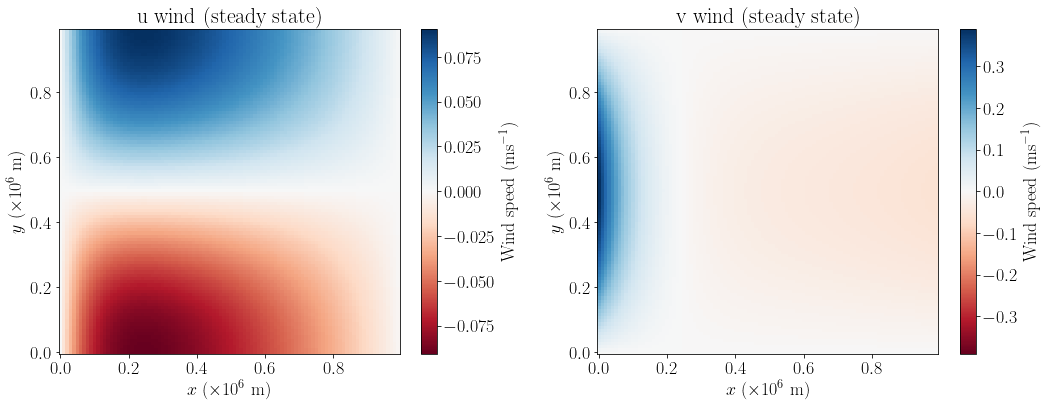

In [9]:
plot_u_and_v_contour_field(
    x_range_steady, y_range_steady, u_steady_state, v_steady_state, 
    "steady state", save_fig=save_fig_param, fig_name="Plots/steady/gyre_uv_contour_steady.pdf")

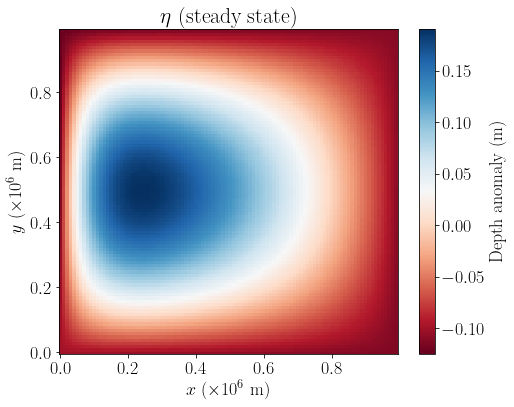

In [10]:
plot_eta_contour_field(
    x_range_steady, y_range_steady, eta_steady_state, 
    "steady state", save_fig=save_fig_param, fig_name="Plots/Steady/gyre_eta_contour_steady.pdf")

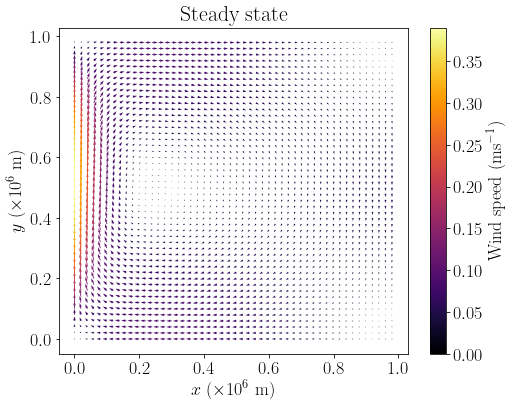

In [11]:
plot_quiver_field(
    x_range_steady, y_range_steady, u_steady_state, v_steady_state, 
    "Steady state", sample_step=2, save_fig=save_fig_param, fig_name="Plots/Steady/gyre_quiver_steady.pdf")

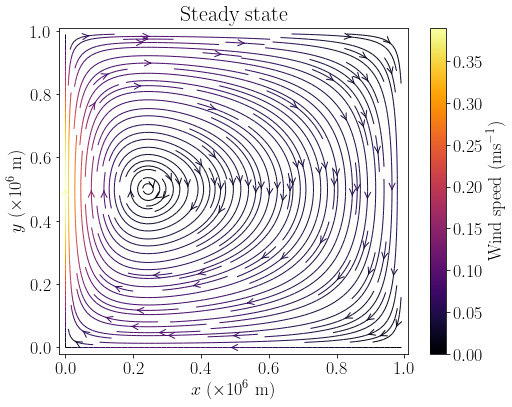

In [12]:
plot_streamlines(x_range_steady, y_range_steady, u_steady_state, v_steady_state, 
"Steady state", streamline_density=2, save_fig=save_fig_param, fig_name="Plots/Steady/gyre_streamlines_steady.pdf")

## Numerical Model Output

After implementing the model described previously, analysis was made of the model outputs after running for just over a single day, i.e., 1250 timesteps at $\Delta t = 70$ s. The figures below shows line profiles through various cross-sections of the domain, while the remaining panels show similar contour plots as those presented for the steady state solutions above. It is clear to see that system is still in the spin-up phase: conditions are now beginning to become noticeably different from the resting state, but there is little evidence of the east-west asymmetry present in the steady state solutions.  

In [13]:
# Run the model for one day
dx = 10**4   #m
dy = 10**4   #m
dt = 70      #s
nt = 1250

x_range_l, y_range_l, x_range_l_plus_one, y_range_l_plus_one = create_x_y_arakawa_c_arrs_and_grids(dx, dy, consts, 'arrs')
u_array, v_array, eta_array, energy_array = run_gyre_model(dx, dy, dt, nt, output_energy=True)

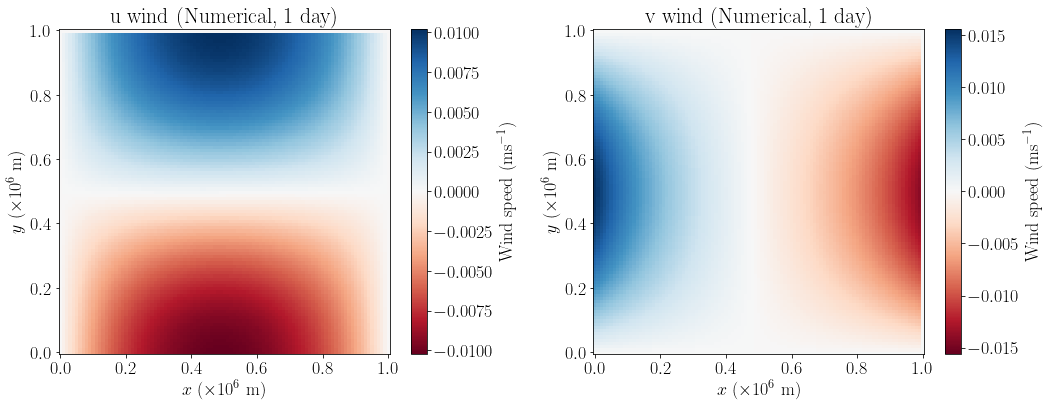

In [14]:
u_array_numer, v_array_numer = reshape_arrays_to_equal_size(u_array, v_array)

plot_u_and_v_contour_field(
    x_range_l_plus_one, y_range_l_plus_one, u_array_numer, v_array_numer, 'Numerical, 1 day',
    save_fig=save_fig_param, fig_name='Plots/Contours/u_v_countour_single_day.pdf')

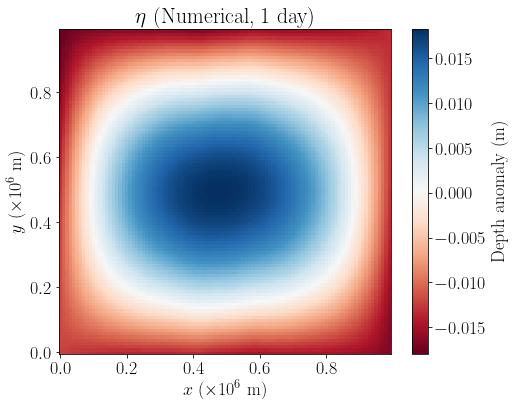

In [15]:
plot_eta_contour_field(
    x_range_l, y_range_l, eta_array, "Numerical, 1 day",
    save_fig=save_fig_param, fig_name='Plots/Contours/eta_countour_single_day.pdf')

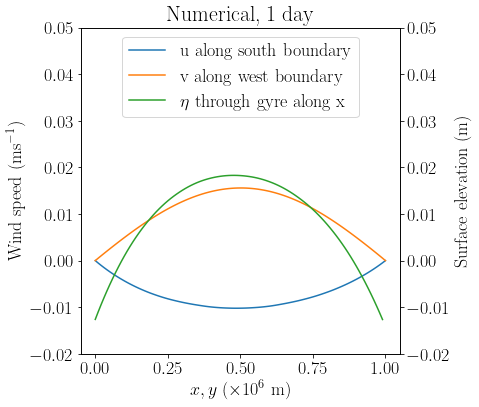

In [16]:
graph_lims = [-0.02, 0.05, -0.02, 0.05]
plot_south_and_west_boundaries_and_gyre_mid(
    x_range_l_plus_one, y_range_l_plus_one, u_array, v_array, eta_array, 'Numerical, 1 day', graph_lims,
    save_fig=save_fig_param, fig_name='Plots/Profiles/line_profiles_single_day.pdf')

Continuing the integration through to 70,000 timesteps, such that the system has had ample time to reach steady state, the model outputs are in excellent agreement with the analytical solutions shown in the previous section. The telltale western bias is clearly present in the $\eta$ and $v$ contour plots, and this is also reflected in the line profiles shown in the upper left figure. The $v$ component of wind does not display any skewness and this is to be expected, since we don't anticipate that there should be any discrimination between north and south when considering meridionally directed wind. 

The east-west asymmetry in the solutions can be readily understood by considering the effects that Rossby waves have on the system. [Stommel, 1948] showed that the inclusion of a Coriolis parameter which is a linear function of latitude directly results in an inequality in the coefficients describing the $x$ component of the streamfunction. In other words, a bias emerges between the two sides of the domain. This dependence of the Coriolis parameter on latitude is the definition of the restoring force which enables Rossby oscillations. As such, it can be concluded that the presence of Rossby waves in the model is the cause of the westward strengthening of the boundary current, which is at the expense of the eastern flow.

In [17]:
# Run model steady state is definitely reached, 70,000 timesteps
dx = 10**4   #m
dy = 10**4   #m
dt = 70      #s
nt = 70000   

x_range_l, y_range_l, x_range_l_plus_one, y_range_l_plus_one = create_x_y_arakawa_c_arrs_and_grids(dx, dy, consts, 'arrs')
u_array, v_array, eta_array, energy_array = run_gyre_model(dx, dy, dt, nt, output_energy=True)

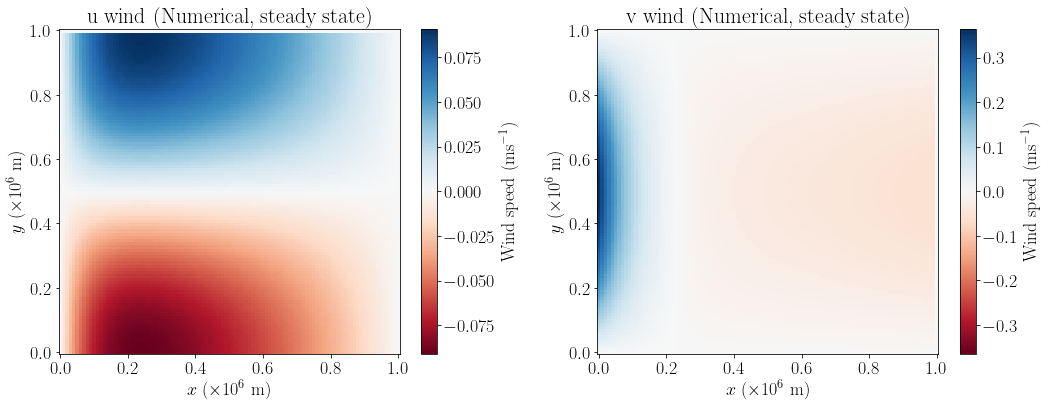

In [18]:
u_array_numer, v_array_numer = reshape_arrays_to_equal_size(u_array, v_array)

plot_u_and_v_contour_field(
    x_range_l_plus_one, y_range_l_plus_one, u_array_numer, v_array_numer, 'Numerical, steady state',
    save_fig=save_fig_param, fig_name='Plots/Contours/u_v_countour_steady_state.pdf')

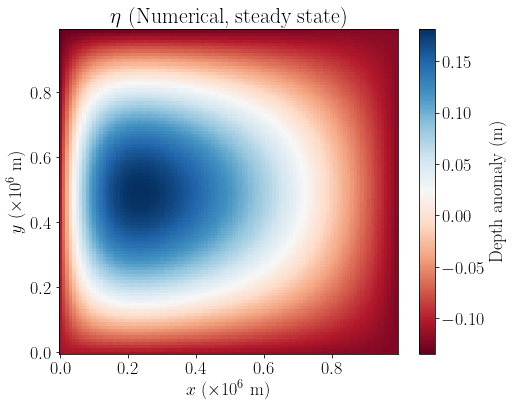

In [19]:
plot_eta_contour_field(
    x_range_l, y_range_l, eta_array, "Numerical, steady state",
    save_fig=save_fig_param, fig_name='Plots/Contours/eta_countour_steady_state.pdf')

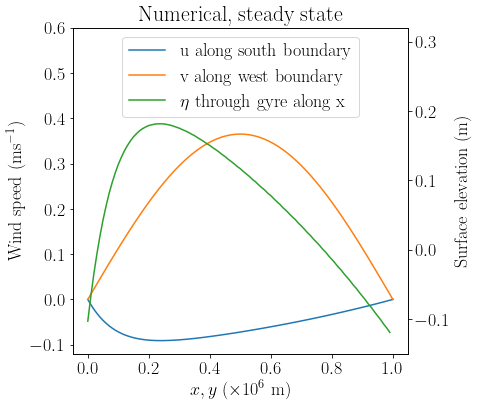

In [20]:
graph_lims = [-0.12, 0.6, -0.15, 0.32]
plot_south_and_west_boundaries_and_gyre_mid(
    x_range_l_plus_one, y_range_l_plus_one, u_array, v_array, eta_array, 'Numerical, steady state', graph_lims,
    save_fig=save_fig_param, fig_name='Plots/Profiles/line_profiles_steady.pdf')

## Model Comparisons

From quick inspection of the relevant scales, it can be seen that the perturbation magnitudes from the model outputs are in excellent agreement with the analytical solution. To explore this further, the plots below show the difference in the fields between the numerical and analytical solutions.

Comparing the maximum difference between the models to the maximum magnitude of the numerical output reveals that the numerical model varies by as much as $1.7 \%$ in $u$, $7.1 \%$ in $v$, and $8.8 \%$ in $\eta$. While this error is reasonable for the $u$ outputs, the $v$ and $\eta$ errors are larger than desired. Examining the distribution of these errors across the domain reveals the source of these large errors. 

There is an interesting shape to the errors presented in the $u$ domain, though there is no obvious explanation for why this specific distribution should occur. Furthermore, this structure is highly dependent on the number of timestep used to generate the output, even after reaching steady state, indicating that this is likely dominated by noise and not worth investigating further.

For $v$, the numerical model describes the diffuse region very accurately, while the western boundary current is underestimated quite strongly towards the fastest part of the flow. This could be due to the simplified shallow water equations used in this particular solver, which omit any non-linear effects and may diminish the coupling between the forcings and the response. 

The similarity between the error distribution in $v$ and $\eta$ are completely expected from consideration of vortex dynamics: since $v$ is the dominant component of the flow, this should have the greatest influence on the pressure at the western boundary. And because the surface elevation responds directly to pressure differences, a difference in one field will cause a difference in the other. It is also sensible that the errors in the two fields are in antiphase: wind speeds which are slower than expected result in smaller pressure differences, and a corresponding positive error in the surface elevation. 

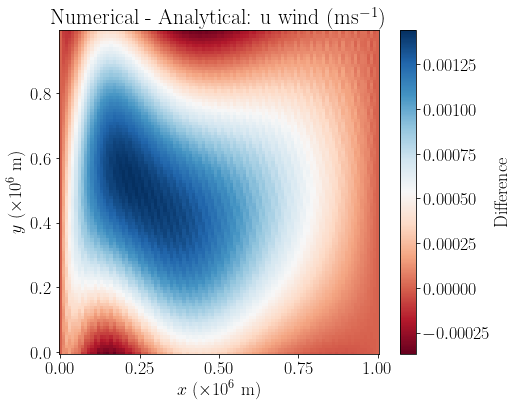

In [21]:
# Now investigate differences between steady state and numerical solutions
# This is NOT the exact way to do these comparisons, since the steady state solutions
# are aligned to the xy grid and the numerical solutions are offset, but this method gives a 
# good enough impression of the scales/locations of error.

# This is also not a good way to make the shapes equal. See above comments
# Pad the steady state arrays to the same size as the numerical solutions
u_steady_state_padded = np.pad(u_steady_state, pad_width=((0,0),(0,1)))

plot_comparison_numerical_analytical(
    x_range_l_plus_one, y_range_l, u_array, u_steady_state_padded, 'u wind (ms$^{-1}$)',
    save_fig=save_fig_param, fig_name='Plots/Comparison/comparison_u.pdf')

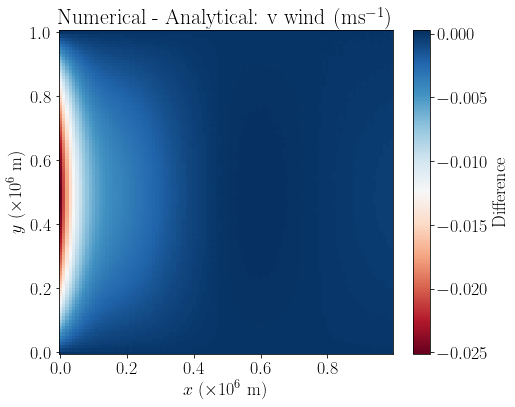

In [22]:
v_steady_state_padded = np.pad(v_steady_state, pad_width=((0,1),(0,0)))

plot_comparison_numerical_analytical(
    x_range_l, y_range_l_plus_one, v_array, v_steady_state_padded, 'v wind (ms$^{-1}$)',
    save_fig=save_fig_param, fig_name='Plots/Comparison/comparison_v.pdf')

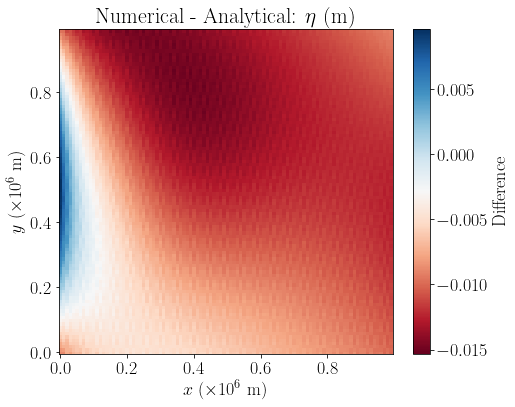

In [23]:
plot_comparison_numerical_analytical(
    x_range_l, y_range_l, eta_array, eta_steady_state, '$\\eta$ (m)',
    save_fig=save_fig_param, fig_name='Plots/Comparison/comparison_eta.pdf')

## Evaluation of System Energy

To explore whether the system converges to a steady state, evaluation of the system energy was made for two different grid resolutions. The energy in the system was calculated using:
$$
E = \int_0^L \int_0^L \frac{1}{2} \rho \left[ H \left(u^2 + v^2 \right) + g \eta^2 \right]dx dy \: . \tag{4}
$$
It is important to make sure in this calculation that the model outputs are aligned onto the same grid for accuracy. For convenience, the code averages $u$ and $v$ values onto the $\eta$ grid. The figures below shows the time series of the perturbation energy as the system reaches steady state, with the first figure showing the result for the setup we have been using for the previous sections, $dx = dy = 10^4$ and $dt = 70$ s. The second figure shows the output from a grid with double the resolution in $x,y$, and a corresponding change in timestep as governed by 2D CFL criterion. Immediately, it can be seen that both profiles are extremely similar, with both reaching steady state energies of $2.9 \times 10^{15}$ J at approximately 30 days after initiation. There is a slight overshoot in the energy for the profile in the left panel which is not present in the right profile, which can be considered an artefact of the coarser grid. The large similarity between profiles validates the analysis made at the beginning of this report - specifically, the choices made for the gridspacing and timestep which would most efficiently capture the important dynamics of this system.

As the model resolution increases and the finite difference approximation tends toward a continuum, we should expect the outputs to converge towards the exact solution. One simple estimator of this is to measure the energy difference between the numerical and analytical solutions (i.e., the energy which has failed to be modelled by the numerical approximation), where this difference should tend to zero as the model resolution improves. This was achieved by using perturbation energy equation above to calculate the energy of the difference field between the model and analytical solutions. The energy difference in the lower resolution, $dx = 10^4$ m model is $7.00 \times 10^{12}$ J, while for the higher resolution $dx = 0.5 \times 10^4$ m model the difference is $2.65 \times 10^{12}$ J, a factor of 2.6 times smaller. Therefore, we can be confident saying that this model is converging to the exact solution as the resolution is increasing.

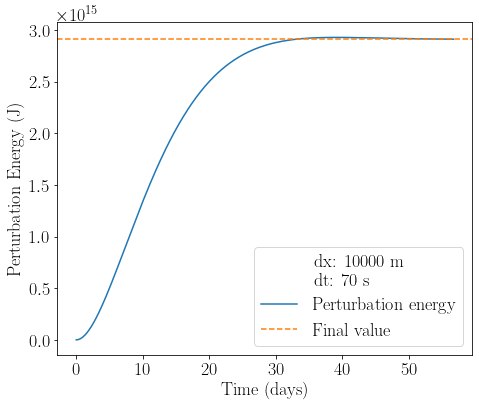

In [24]:
plot_energy_against_time(energy_array, dt, nt, dx, save_fig=save_fig_param, fig_name='Plots/Energy/energy_dt_70.pdf')

# What does this plot tell me about the quality of the assumptions made for model?
# I'm guessing the assumptions are good??
# Steady state reached after roughly 30 days
# Find some value in the literature of what the steady state energy is

In [25]:
# Need to also calculate the energy contained in the differences between analytical and numerical

u_diff = u_array - u_steady_state_padded
v_diff = v_array - v_steady_state_padded
eta_diff = eta_array - eta_steady_state

energy_diff = calculate_perturbation_energy(u_diff, v_diff, eta_diff, dx, dy)
print(energy_diff)

7002905513150.504


In [26]:
# Now, run the model with half the grid spacing
# Change dt based on 2D CFL 

dx = 0.5*10**4   #m
dy = 0.5*10**4   #m
dt = 30       #s 35s seems to be unstable??
nt = 140000   #

x_range_l, y_range_l, x_range_l_plus_one, y_range_l_plus_one = create_x_y_arakawa_c_arrs_and_grids(dx, dy, consts, 'arrs')
u_array, v_array, eta_array, energy_array = run_gyre_model(dx, dy, dt, nt, output_energy=True)

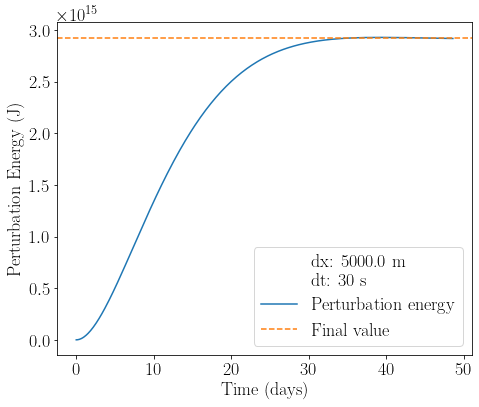

In [27]:
plot_energy_against_time(energy_array, dt, nt, dx, save_fig=save_fig_param, fig_name='Plots/Energy/energy_dt_30.pdf')
# Appears to be a smaller overshoot above the final value line
# Also appears to reach steady state at a slightly later time that the above.

In [28]:
# get the steady state solutions on this new grid spacing 
dx = 0.5*10**4
dy = 0.5*10**4
eta_0 = -0.11263278141371519 # Found from numerical sims below
x_range_steady, y_range_steady, u_steady_state, v_steady_state, eta_steady_state = get_steady_state_solutions(dx, dy, eta_0)

In [29]:
# Need to also calculate the energy contained in the differences between analytical and numerical???
u_steady_state_padded = np.pad(u_steady_state, pad_width=((0,0),(0,1)))
v_steady_state_padded = np.pad(v_steady_state, pad_width=((0,1),(0,0)))

u_diff = u_array - u_steady_state_padded
v_diff = v_array - v_steady_state_padded
eta_diff = eta_array - eta_steady_state

energy_diff = calculate_perturbation_energy(u_diff, v_diff, eta_diff, dx, dy)
print(energy_diff)

2650621350018.373


In [30]:
# Get eta_0 integration constant for the analytical model
ny_half = int(consts['L']/(2*dy))

eta_0 = eta_array[ny_half, 0]
print(eta_0)

-0.11263278141371519


# Attempt at Semi Lagrangian

The code below shows my attempt at trying to extend the code to run using a semi-lagrangian method, where the source terms are computed in the same way as before (using the same functions even), and the advection is handled using semi-lagrangian methods. This was attemped on the same staggered, Arakawa-C grid as with the FBT code above, which turned out to present many more issues than anticipated. 

The individual pieces all appear to work (getting departure points, using RegularGridInterpolator to create functions which can quickly interpolate a set of departure point coordinates, etc.), but shape issues prevent the code from running when putting all of the pieces together. The current issue preventing the code from running is in finding the departure points, the fact that $x$ and $u$ grids are not the same shape, and similar for $y$ and $v$. This cannot be fixed by thoughtlessly changing one to be the same shape as the other, since how this is done will affect the rest of the code too. It would also be necessary to interpolate the $u$ and $v$ data onto the $xy$ grid before doing this. I'm sure this can be solved with a little more thought, but unfortunately I am out of time. 

In [31]:
def get_departure_points(coord_grid, wind_grid, dt):
    dep_point_grid = coord_grid - wind_grid*dt
    return dep_point_grid

def fix_dep_points_outside_domain(dep_points_grid, d, consts=consts):
    L = consts['L']
    dep_points_grid = np.where(dep_points_grid < 0,     0, dep_points_grid)
    dep_points_grid = np.where(dep_points_grid > L+d, L+d, dep_points_grid)
    return dep_points_grid

def zip_dep_point_coords(x_mat, y_mat):
    return np.stack((x_mat, y_mat), axis = 2)

test_x = np.array(
    [
        [2,3,5,3],
        [6,5,3,2],
    ]
)

test_y = np.array(
    [
        [4,3,2,1],
        [8,5,2,8],
    ]
)

print(zip_dep_point_coords(test_x, test_y))

x_range_test = np.arange(0,20,1)
y_range_test = np.arange(0,20,1)

x_grid_test, y_grid_test = np.meshgrid(x_range_test, y_range_test)

u_grid_test = np.ones_like(x_grid_test)*3
u_grid_test[-1:,:] = 15
dt = 0.1

dep_points = get_departure_points(x_grid_test, u_grid_test, dt)

print(dep_points)

# Now, need to figure out the function which interpolates values between grid points in 2D space
# So, use get dep point func to get the nearest dep point in x.
# Then, do the same to get the dep point for y
# Then, interpolate the source terms in 2D using an interp function.
# can this be done with numpy really quickly???



[[[2 4]
  [3 3]
  [5 2]
  [3 1]]

 [[6 8]
  [5 5]
  [3 2]
  [2 8]]]
[[-0.3  0.7  1.7  2.7  3.7  4.7  5.7  6.7  7.7  8.7  9.7 10.7 11.7 12.7
  13.7 14.7 15.7 16.7 17.7 18.7]
 [-0.3  0.7  1.7  2.7  3.7  4.7  5.7  6.7  7.7  8.7  9.7 10.7 11.7 12.7
  13.7 14.7 15.7 16.7 17.7 18.7]
 [-0.3  0.7  1.7  2.7  3.7  4.7  5.7  6.7  7.7  8.7  9.7 10.7 11.7 12.7
  13.7 14.7 15.7 16.7 17.7 18.7]
 [-0.3  0.7  1.7  2.7  3.7  4.7  5.7  6.7  7.7  8.7  9.7 10.7 11.7 12.7
  13.7 14.7 15.7 16.7 17.7 18.7]
 [-0.3  0.7  1.7  2.7  3.7  4.7  5.7  6.7  7.7  8.7  9.7 10.7 11.7 12.7
  13.7 14.7 15.7 16.7 17.7 18.7]
 [-0.3  0.7  1.7  2.7  3.7  4.7  5.7  6.7  7.7  8.7  9.7 10.7 11.7 12.7
  13.7 14.7 15.7 16.7 17.7 18.7]
 [-0.3  0.7  1.7  2.7  3.7  4.7  5.7  6.7  7.7  8.7  9.7 10.7 11.7 12.7
  13.7 14.7 15.7 16.7 17.7 18.7]
 [-0.3  0.7  1.7  2.7  3.7  4.7  5.7  6.7  7.7  8.7  9.7 10.7 11.7 12.7
  13.7 14.7 15.7 16.7 17.7 18.7]
 [-0.3  0.7  1.7  2.7  3.7  4.7  5.7  6.7  7.7  8.7  9.7 10.7 11.7 12.7
  13.7 14.7 15.7 16.

In [32]:
# Now test the interpolator function...

from scipy.interpolate import RegularGridInterpolator

# test data
source_terms_test = np.array(
    [
        [3,6,4,3,8,6,3],
        [9,7,5,3,7,8,4],
        [6,8,9,5,3,2,5],
        [0,7,4,2,6,4,7],
    ]
)

# Need to input the list of arrays which specifies how points are sampled along each axis
# In the real thing, this would be the x_range and y_range arrays for u and v.
# Remember, this needs to be y,x ordered. 
points = (np.array([0,1,2,3]), np.array([0,1,2,3,4,5,6]))

# Now, define an interpolating function from these bits.
test_interp_func = RegularGridInterpolator(points, source_terms_test)

# test an inerpolation
# let's try to get the value at 2.5, 2.5
# This should be (9+5+4+2)/4 = 5

sample_loc = np.array(
    [
        [   
             #y   #x   coords to interpolate
            [2.5, 2.5],
            [2.8, 3.4], 
        ],
        [
            [0.1, 0.9],
            [1.1, 1.5],
        ]
    ]
)
# So the sample locs needs an extra np dimension for the x,y, coords

# Then, running the function will output the results in a similar shape as sample_loc
test_interp = test_interp_func(sample_loc)
print(test_interp)



[[5.   3.72]
 [5.85 6.25]]


In [33]:
test_bounds_array = np.array(
    [[3,4,3,-1,6,5,0],
    [0,11,4,5,4,3,2]]
)

test_bounds_array = np.where(test_bounds_array < 0, 0, test_bounds_array)
test_bounds_array = np.where(test_bounds_array > 10, 10, test_bounds_array)

print(test_bounds_array)

[[ 3  4  3  0  6  5  0]
 [ 0 10  4  5  4  3  2]]


In [34]:
# def create_x_y_arrs_and_grids(dx, dy, consts=consts):
#     x_range = np.arange(0, consts['L'], dx)
#     y_range = np.arange(0, consts['L'], dy)

#     # Create meshgrids for the u and v
#     x_grid, y_grid = np.meshgrid(x_range, y_range)

#     return[x_range, y_range, x_grid, y_grid]

# _,_,x_grid,y_grid = create_x_y_arrs_and_grids(10**4, 10**4)
# print(y_grid)

# def create_init_grids(nx, ny):
#     eta_mat = np.zeros((ny, nx))
#     u_mat = np.zeros_like(eta_mat)
#     v_mat = np.zeros_like(eta_mat)
#     return [eta_mat, u_mat, v_mat]

# def get_tau_x_matrix(y_matrix, consts=consts):
#     tau_0 = consts['tau_0']
#     L = consts['L']
#     tau_x = -tau_0 * np.cos(np.pi*y_matrix/L)
#     return tau_x

# def get_tau_y_matrix(x_matrix):
#     return np.zeros_like(x_matrix)


In [35]:
def run_gyre_model_semilag(dx, dy, dt, nt, consts=consts, output_energy=False):
    """
    Main function for running the numerical ocean gyre model

    Args:
        dx (float): grid spacing in x (m)
        dy (float): grid spacing in y (m)
        dt (float): timestep (s)
        nt (int): number of timesteps to iterate for
        consts (dict optional): dictionary of constant. Defaults to consts.
        output_energy (bool, optional): flag for enabling system energy output. Defaults to False
    Returns:
        u_mat (2D array): grid of iterated u wind components (m/s)
        v_mat (2D array): grid of iterated v wind components (m/s)
        eta_mat (2D array): grid of iterated depth anomalies (m)
        perturbation_energy_array (1D array): time series of energy in system at each timestep
    """
    L = consts['L']
    nx = int(L/dx)
    ny = int(L/dy)

    # Get x,y matrices for u and v grids
    grids = create_x_y_arakawa_c_arrs_and_grids(dx, dy)
    local_x_matrix_for_u_grid, interp_y_matrix_for_u_grid, interp_x_matrix_for_v_grid, local_y_matrix_for_v_grid = grids

    # Create arrays 
    x_range_for_u_grid   = np.arange(0, consts['L']+dx, dx)
    x_range_for_v_grid   = np.arange(0, consts['L']   , dx) + 0.5*dx
    x_range_for_eta_grid = np.arange(0, consts['L']   , dx) + 0.5*dx
    y_range_for_u_grid   = np.arange(0, consts['L']   , dy) + 0.5*dy
    y_range_for_v_grid   = np.arange(0, consts['L']+dy, dy)
    y_range_for_eta_grid = np.arange(0, consts['L']   , dy) + 0.5*dy

    x_grid, y_grid = np.meshgrid(x_range_for_u_grid, y_range_for_v_grid)

    # Get eta, u, v arrays of the correct shape
    eta_mat, u_mat, v_mat = create_init_arakawa_c_grids(nx, ny)

    # Precalculate constant tau matrices
    tau_x_matrix_for_u_grid = get_tau_x_matrix_for_u_grid(interp_y_matrix_for_u_grid)
    tau_y_matrix_for_v_grid = get_tau_y_matrix_for_v_grid(interp_x_matrix_for_v_grid)

    # Initialise output energy array
    perturbation_energy_array = []

    # Loop over timesteps
    for t in range(nt):
        # Get the source terms at each location
        eta_source = iterate_eta_mat(eta_mat, u_mat, v_mat, dx, dy, dt, return_as_source=True)
        u_source = iterate_u_mat(
            u_mat, v_mat, eta_mat, interp_y_matrix_for_u_grid, tau_x_matrix_for_u_grid, dx, dt,
            return_as_source=True
        )
        v_source = iterate_v_mat(
            u_mat, v_mat, eta_mat, local_y_matrix_for_v_grid, tau_y_matrix_for_v_grid, dy, dt,
            return_as_source=True
        )

        # Get departure points
        # TODO: Make sure u and v points need to be interpolated onto x,y grid. 
        x_dep_points = get_departure_points(x_grid, u_mat, dt)
        y_dep_points = get_departure_points(y_grid, v_mat, dt)

        print(np.shape(x_dep_points))
        print(np.shape(y_dep_points))

        # Fix the departure points outside the domain
        fix_dep_points_outside_domain(x_dep_points, dx)
        fix_dep_points_outside_domain(y_dep_points, dy)

        # Construct interpolation func for u,v,eta source terms
        grid_points_eta = (y_range_for_eta_grid, x_range_for_eta_grid)
        grid_points_u = (y_range_for_u_grid, x_range_for_u_grid)
        grid_points_v = (y_range_for_v_grid, x_range_for_v_grid)
        
        # First arg is the grid which the current variables are defined on
        # Second arg are the values at these grid points
        interp_func_eta_source = RegularGridInterpolator(grid_points_eta, eta_source)
        interp_func_u_source = RegularGridInterpolator(grid_points_u, u_source)
        interp_func_v_source = RegularGridInterpolator(grid_points_v, v_source)

        # get interpolated source values
        zipped_dep_coords = zip_dep_point_coords(x_dep_points, y_dep_points)
        eta_source_at_dep_points = interp_func_eta_source(zipped_dep_coords)
        u_source_at_dep_points = interp_func_u_source(zipped_dep_coords)
        v_source_at_dep_points = interp_func_v_source(zipped_dep_coords)

        # Construct interp func for u,v,eta values
        interp_func_eta = RegularGridInterpolator(grid_points_u, eta_mat)
        interp_func_u = RegularGridInterpolator(grid_points_v, u_mat)
        interp_func_v = RegularGridInterpolator(grid_points_eta, v_mat)

        # get interpolated current values
        eta_at_dep_points = interp_func_eta(zipped_dep_coords)
        u_at_dep_points = interp_func_u(zipped_dep_coords)
        v_at_dep_points = interp_func_v(zipped_dep_coords)

        # Put it all together
        new_eta_mat = eta_at_dep_points + (eta_source + eta_source_at_dep_points)*dt/2
        new_u_mat = u_at_dep_points + (u_source + u_source_at_dep_points)*dt/2
        new_v_mat = v_at_dep_points + (v_source + v_source_at_dep_points)*dt/2

        # If enabled in input flag, calculate and output energy of perturbation
        if output_energy:
            perturbation_energy_array.append(calculate_perturbation_energy(new_u_mat, new_v_mat, new_eta_mat, dx, dy))

        # Copy new arrays to old arrays
        eta_mat = new_eta_mat.copy()
        u_mat = new_u_mat.copy()
        v_mat = new_v_mat.copy()

    return [u_mat, v_mat, eta_mat, perturbation_energy_array]

In [36]:
# Run the model for one day
dx = 10**4   #m
dy = 10**4   #m
dt = 70      #s
nt = 1250

x_range_l, y_range_l, x_range_l_plus_one, y_range_l_plus_one = create_x_y_arakawa_c_arrs_and_grids(dx, dy, consts, 'arrs')
u_array, v_array, eta_array, energy_array = run_gyre_model_semilag(dx, dy, dt, nt, output_energy=True)

ValueError: operands could not be broadcast together with shapes (101,101) (100,101) 